In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
!pip install unsloth
!pip install --force-reinstall --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-req-build-byivbplm
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-req-build-byivbplm
  Resolved https://github.com/unslothai/unsloth.git to commit bdf0cd6033595be4e7ed23d0d002bb176d343152
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2025.1.7-py3-none-any.whl size=174896 sha256=2b757a0b22fcf0e3a7d17e3a5d0bc25fcb3a703e6eafd41b6c65ff327f0b893a
  Stored in directory: /tmp/pip-ephem-wheel-cache-0d6z_zbr/wheels/d1/17/05/850ab10c33284a4763b0595cd8ea9d01fce6e221cac24b3c01
Successfully built unsloth
  Attempting uninstall: unsloth
    Found existing installation: unsloth 2025.1.7
    Uninstalling unsloth-2025.1.7:
      Successfully uninstalled unsloth-2025.1.7


In [3]:
from unsloth import FastLanguageModel  # FastVisionModel for LLMs
import torch
max_seq_length = 2048  # Choose any! We auto support RoPE Scaling internally!
load_in_4bit = False  # Use 4bit quantization to reduce memory usage. Can be False.
name = "DrishtiSharma/HINDI-GEMMA-9B-B20"
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = name,
    max_seq_length = max_seq_length,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: If you want to finetune Gemma 2, install flash-attn to make it faster!
To install flash-attn, do the below:

pip install --no-deps --upgrade "flash-attn>=2.6.3"
==((====))==  Unsloth 2025.1.7: Fast Gemma2 patching. Transformers: 4.47.1.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.0. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.1.7 patched 42 layers with 42 QKV layers, 42 O layers and 42 MLP layers.


In [5]:
!pip install datasets tqdm
import pandas as pd
from datasets import load_dataset
import os

In [6]:
FastLanguageModel.for_inference(model)
from tqdm import tqdm
tqdm.pandas()

In [7]:
dataset = load_dataset("1-800-LLMs/Test-Collection", data_files="MMMLU_H.csv", split="train")
df = dataset.to_pandas()
print(len(df))
df

14042


Input Output  \
0      Q पर दिए गए क्षेत्र विस्तार Q(sqrt(2), sqrt(3)...      B   
1      मान लीजिए S_5 में p = (1, 2, 5, 4)(2, 3) है. S...      C   
2      दिए गए बहुपद के संकेतित परिमित क्षेत्र में गुण...      D   
3      कथन 1 | नॉन-एबेलियन ग्रुप का एक फ़ैक्टर ग्रुप ...      B   
4      दिए गए बहुपद रिंग में दिए गए बहुपदों का गुणनफल...      B   
...                                                  ...    ...   
14037  चीन और कोरिया में धार्मिक परम्पराओं का मुख्य क...      A   
14038  हान राजवंश के समय सूखे के दौरान आम लोग किससे अ...      C   
14039  धर्मशास्त्रीय शब्द होमोओसिओस का अर्थ निम्नलिखि...      B   
14040  जापानी मूल मिथक के अनुसार, अमातरासु को किसने अ...      B   
14041  ऑगस्टस का नुमेन निम्नलिखित में से किस विशेषता ...      A   

             Sub-Domain Dataset  
0      abstract_algebra    MMLU  
1      abstract_algebra    MMLU  
2      abstract_algebra    MMLU  
3      abstract_algebra    MMLU  
4      abstract_algebra    MMLU  
...                 ...     ...  
14037   world_religions    MMLU  
14038   world_religions    MMLU  
14039   world_religions    MMLU  
14040   world_religions    MMLU  
14041   world_religions    MMLU  

[14042 rows x 4 columns]

In [8]:
df['tok'] = df['Input'].apply(lambda x: len(tokenizer.encode(x)))

In [9]:
print(f"Average 'tok' value: {df['tok'].mean()}")
print(f"Max 'tok' value: {df['tok'].max()}")

Average 'tok' value: 180.577624270047
Max 'tok' value: 1917


In [10]:
df = df.sort_values('tok', ascending=False)

In [11]:
!pip install matplotlib

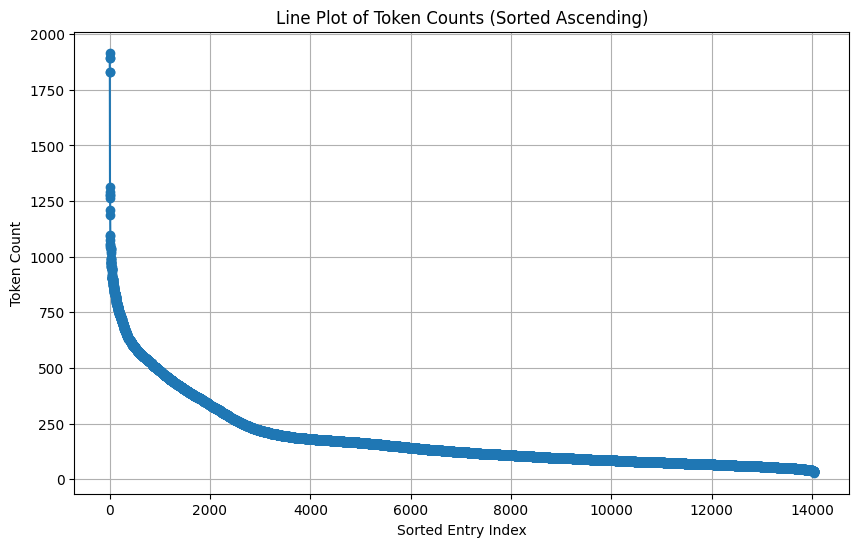

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df['tok'].values, marker='o', linestyle='-')
plt.xlabel('Sorted Entry Index')
plt.ylabel('Token Count')
plt.title("Line Plot of Token Counts (Sorted Ascending)")
plt.grid(True)
plt.show()

In [13]:
df.head(10)

Input Output  \
1262   सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      B   
1202   सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      A   
1289   सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      A   
1246   सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      D   
1358   सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      D   
5938   यह प्रश्न निम्नलिखित जानकारी से संबंधित है।\nस...      A   
5874   यह प्रश्न निम्नलिखित जानकारी से संबंधित है।\nस...      B   
12115  साल 1993 में, एक पशुपालक किसान को 20 एकड़ के स...      A   
10876  एक भूमि-विकास कंपनी के पास दक्षिणपश्चिम में 40...      C   
11923  साल 1993 में, एक ज़मींदार के पास एक अंगूर के ब...      C   

                      Sub-Domain Dataset   tok  
1262            college_medicine    MMLU  1917  
1202            college_medicine    MMLU  1894  
1289            college_medicine    MMLU  1892  
1246            college_medicine    MMLU  1831  
1358            college_medicine    MMLU  1830  
5938   high_school_world_history    MMLU  1313  
5874   high_school_world_history    MMLU  1292  
12115           professional_law    MMLU  1279  
10876           professional_law    MMLU  1277  
11923           professional_law    MMLU  1266

In [14]:
"""from tqdm import tqdm
import torch
def generate_responses_phi4_batched(df, tokenizer, model, batch_size=8):
    responses = []
    for i in tqdm(range(0, len(df), batch_size), desc="Processing Batches"):
        batch = df['Input'][i:i + batch_size].tolist()
        prompts = [f"### INPUT : {text} ### MCQ ### OUTPUT :" for text in batch]
        messages = [{"role": "user", "content": prompt} for prompt in prompts]
        inputs = [tokenizer.apply_chat_template([msg], tokenize=True, add_generation_prompt=True, return_tensors="pt") for msg in messages]
        max_length = max(input_tensor.size(1) for input_tensor in inputs)
        padded_inputs = []
        for input_tensor in inputs:
            pad_size = max_length - input_tensor.size(1)
            padded_tensor = torch.nn.functional.pad(input_tensor, (0, pad_size), value=tokenizer.pad_token_id)
            padded_inputs.append(padded_tensor)
        batch_inputs = torch.cat(padded_inputs, dim=0).to("cuda")
        outputs = model.generate(input_ids=batch_inputs, max_new_tokens=20, use_cache=True, temperature=0.1, min_p=0.1, pad_token_id=tokenizer.eos_token_id)
        batch_responses = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        for response in batch_responses:
            processed_response = response.split("### OUTPUT :\nassistant")[-1].strip()
            responses.append(processed_response)
    df['Response'] = responses
    return df"""

'from tqdm import tqdm\nimport torch\ndef generate_responses_phi4_batched(df, tokenizer, model, batch_size=8):\n    responses = []\n    for i in tqdm(range(0, len(df), batch_size), desc="Processing Batches"):\n        batch = df[\'Input\'][i:i + batch_size].tolist()\n        prompts = [f"### INPUT : {text} ### MCQ ### OUTPUT :" for text in batch]\n        messages = [{"role": "user", "content": prompt} for prompt in prompts]\n        inputs = [tokenizer.apply_chat_template([msg], tokenize=True, add_generation_prompt=True, return_tensors="pt") for msg in messages]\n        max_length = max(input_tensor.size(1) for input_tensor in inputs)\n        padded_inputs = []\n        for input_tensor in inputs:\n            pad_size = max_length - input_tensor.size(1)\n            padded_tensor = torch.nn.functional.pad(input_tensor, (0, pad_size), value=tokenizer.pad_token_id)\n            padded_inputs.append(padded_tensor)\n        batch_inputs = torch.cat(padded_inputs, dim=0).to("cuda")\n   

In [15]:
df[14000:]

Input Output  \
2399   100 का तीन पांचवा भाग क्या है? ###  A) 3 B) 5 ...      D   
2277   कौन सी संख्या 7 का गुणज है? ###  A) 27 B) 48 C...      C   
7890   तीन स्टूज में से कौन अन्य से संबंधित नहीं था? ...      B   
2274   −8 • (−4) का गुणनफल ज्ञात कीजिए। ###  A) −4 B)...      C   
7667   लौवर संग्रहालय कहां है? ###  A) पेरिस B) ल्योन...      A   
7410   पेरेग्रन किस तरह का जानवर है? ###  A) मूज़  B) ...      C   
669    पानी का pH मान कितना है? ###  A) 3.5 B) 7 C) 1...      B   
3204   Python 3 में, निम्न में से कौन सा फ़्लोर डिवीज...      B   
7421   आप एक युवा गाय को क्या कहते हैं?  ###  A) घोड़...      D   
2107   किस संख्या का निरपेक्ष मान 5 से अधिक है? ###  ...      A   
38     परिमित क्षेत्र Z_7 के लिए जनरेटर पता करें. ###...      C   
7529   आपका हॉलक्स क्या है? ###  A) कान का लोब B) जीभ...      D   
2126   एक दशक में कितने वर्ष होते हैं? ###  A) 5 B) 1...      B   
7722   इनमें से कौन मसाला नहीं है? ###  A) डिल B) सौं...      C   
1552   WPA किस प्रकार के एन्क्रिप्शन का उपयोग करता है...      C   
13949  भक्ति का प्रायः क्या अनुवाद किया जाता है? ### ...      C   
3142   निम्नलिखित में से कौन सा एक रेडियोधर्मी तत्व ह...      C   
2112   Compute 22 / 2 + 9. ###  A) 10 B) 11 C) 20 D) ...      C   
5077   निम्नलिखित में से कौन द्वितीयक प्रबलक है? ### ...      C   
7872   बेसबॉल में कितनी गेंदें वॉक करती हैं? ###  A) ...      D   
7737   इनमें से कौन सी फलियां नहीं हैं? ###  A) फलिया...      C   
2150   8 + 8 ÷ 2 + 2 = ###  A) 4 B) 8 C) 10 D) 14 ###...      D   
3161   निम्नलिखित में से किसे मेटलॉइड माना जाता है? #...      C   
8041   इनमें से कौन सी मिर्च का प्रकार नहीं है? ###  ...      B   
77     वलय Z x Z की विशेषता पता करें. ###  A) 0 B) 3 ...      A   
7744   जिराफ़ की कितनी आँखें होती हैं? ###  A) एक बार...      B   
1766   नीले रंग का पूरक रंग है ###  A) मैजेंटा B) पील...      B   
3899   सरकार इसका उपयोग करके मुद्रास्फीति को मापती है...      C   
7548   सर्वहारा वर्ग क्या है? ###  A) बेघर B) राजपरिव...      D   
7686   अरबी अंक '2' को कैसे लिखा जाता है? ###  A) 2 B...      A   
7971   आइस हॉकी खेल में कितने पीरियड होते हैं? ###  A...      C   
7681   इनमें से कौन सा शब्द सही वर्तनी वाला है? ###  ...      C   
7851   बैकगैमौन कितने खिलाड़ियों का खेल है? ###  A) द...      A   
8138   गेरी एडम्स किस संगठन के अध्यक्ष हैं? ###  A) G...      C   
1190   (1+i)^10 = ###  A) 1 B) i C) 32 D) 32i ### MCQ...      D   
7624   इनमें से कौन सा सामान्यतः ज्ञात निवेश खाता है?...      C   
8005   निम्नलिखित में से कौन सा तत्व धातु है? ###  A)...      D   
2087   −4 +  ( −3 )= ###  A) −7 B) −1 C) 1 D) 7 ### M...      A   
8009   माणिक्य किस रंग का होता है? ###  A) लाल B) काल...      A   
7772   इनमें से कौन सा शब्द क्रिया विशेषण है? ###  A)...      D   
7585   बल = द्रव्यमान = क्या? ###  A) वेग B) दूरी C) ...      C   
2983   एंटीमोनी का प्रतीक … है ###  A) W B) Sb C) Fe ...      B   

                         Sub-Domain Dataset  tok  
2399         elementary_mathematics    MMLU   38  
2277         elementary_mathematics    MMLU   38  
7890                  miscellaneous    MMLU   38  
2274         elementary_mathematics    MMLU   38  
7667                  miscellaneous    MMLU   38  
7410                  miscellaneous    MMLU   38  
669              clinical_knowledge    MMLU   38  
3204   high_school_computer_science    MMLU   38  
7421                  miscellaneous    MMLU   38  
2107         elementary_mathematics    MMLU   38  
38                 abstract_algebra    MMLU   38  
7529                  miscellaneous    MMLU   38  
2126         elementary_mathematics    MMLU   37  
7722                  miscellaneous    MMLU   37  
1552              computer_security    MMLU   37  
13949               world_religions    MMLU   37  
3142          high_school_chemistry    MMLU   37  
2112         elementary_mathematics    MMLU   37  
5077         high_school_psychology    MMLU   37  
7872                  miscellaneous    MMLU   37  
7737                  miscellaneous    MMLU   37  
2150         elementary_mathematics    MMLU   3

In [16]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
input_text = "जोड़ें 46,911 + 653,092 ### A) 699,903 B) 700,003 C) 913,203 D) 1,122,202 ### MCQ ###	Respond with just one letter based on these options : "
prompt = f"### INPUT : {input_text} RESPONSE : "
message = [{"role": "user", "content": prompt}]
inputs = tokenizer.apply_chat_template(message, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
with torch.no_grad():
    outputs = model.generate(input_ids=inputs, max_new_tokens=1, use_cache=True, pad_token_id=tokenizer.eos_token_id, return_dict_in_generate=True, output_scores=True)
    next_token_logits = outputs.scores[0]
probs = F.softmax(next_token_logits, dim=-1)
token_ids_a = tokenizer.encode('A', add_special_tokens=False)[0]
token_ids_b = tokenizer.encode('B', add_special_tokens=False)[0]
token_ids_c = tokenizer.encode('C', add_special_tokens=False)[0]
token_ids_d = tokenizer.encode('D', add_special_tokens=False)[0]
prob_a = probs[0, token_ids_a].item()
prob_b = probs[0, token_ids_b].item()
prob_c = probs[0, token_ids_c].item()
prob_d = probs[0, token_ids_d].item()
print(f"Probability of 'A': {prob_a:.4f}")
print(f"Probability of 'B': {prob_b:.4f}")
print(f"Probability of 'C': {prob_c:.4f}")
print(f"Probability of 'D': {prob_d:.4f}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Probability of 'A': 0.2380
Probability of 'B': 0.3463
Probability of 'C': 0.0992
Probability of 'D': 0.0682


In [17]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
input_text = "दिए गए बहुपद के संकेतित परिमित क्षेत्र में गुणांकों के साथ सभी शून्य बताएं. x^5 + 3x^3 + x^2 + 2x in Z_5 ### A) 0 B) 1 C) 0,1 D) 0,4	### MCQ ### Respond with just one letter based on these options : "
prompt = f"### INPUT : {input_text} RESPONSE : "
message = [{"role": "user", "content": prompt}]
inputs = tokenizer.apply_chat_template(message, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
outputs = model.generate(input_ids=inputs, max_new_tokens=200, use_cache=True, temperature=0.1, min_p=0.1, pad_token_id=tokenizer.eos_token_id)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
processed_response = response.split("### RESPONSE :\nmodel")[-1].strip()
print(f"Generated Response (20 tokens):\n{processed_response}\n")
with torch.no_grad():
    outputs = model.generate(input_ids=inputs, max_new_tokens=1, use_cache=True, pad_token_id=tokenizer.eos_token_id, return_dict_in_generate=True, output_scores=True)
    next_token_logits = outputs.scores[0]
probs = F.softmax(next_token_logits, dim=-1)
token_ids_a = tokenizer.encode('A', add_special_tokens=False)[0]
token_ids_b = tokenizer.encode('B', add_special_tokens=False)[0]
token_ids_c = tokenizer.encode('C', add_special_tokens=False)[0]
token_ids_d = tokenizer.encode('D', add_special_tokens=False)[0]
prob_a = probs[0, token_ids_a].item()
prob_b = probs[0, token_ids_b].item()
prob_c = probs[0, token_ids_c].item()
prob_d = probs[0, token_ids_d].item()
print(f"Probability of 'A': {prob_a:.4f}")
print(f"Probability of 'B': {prob_b:.4f}")
print(f"Probability of 'C': {prob_c:.4f}")
print(f"Probability of 'D': {prob_d:.4f}")

Generated Response (20 tokens):
user
### INPUT : दिए गए बहुपद के संकेतित परिमित क्षेत्र में गुणांकों के साथ सभी शून्य बताएं. x^5 + 3x^3 + x^2 + 2x in Z_5 ### A) 0 B) 1 C) 0,1 D) 0,4	### MCQ ### Respond with just one letter based on these options :  RESPONSE :
model
The correct answer is C. Here's why:

**Understanding the problem:**

We are given a polynomial with coefficients in the finite field Z_5 (the integers modulo 5). We need to find all the roots (or zeros) of this polynomial within Z_5.

**Solving the problem:**

1. **Substitute values:** Since we are working in Z_5, we can substitute the elements of Z_5 (0, 1, 2, 3, 4) into the polynomial to see if they result in 0.

2. **Check for roots:**
   * x = 0: 0^5 + 3(0)^3 + 0^2 + 2(0) = 0 
   * x = 1: 1^5 + 3(1)^3 + 1^2 + 2(1) = 1 + 3 + 1 + 2

Probability of 'A': 0.0537
Probability of 'B': 0.0781
Probability of 'C': 0.1288
Probability of 'D': 0.0690


In [18]:
import torch
import torch.nn.functional as F
input_text = "जोड़ें 46,911 + 653,092 ### A) 699,903 B) 700,003 C) 913,203 D) 1,122,202 ### MCQ ###"
prompt = f"### INPUT : {input_text} RESPONSE : "
message = [{"role": "user", "content": prompt}]
inputs = tokenizer.apply_chat_template(message, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
outputs = model.generate(input_ids=inputs, max_new_tokens=200, use_cache=True, temperature=0.1, min_p=0.1, pad_token_id=tokenizer.eos_token_id)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
processed_response = response.split("### RESPONSE :\nmodel")[-1].strip()
print(f"Generated Response (20 tokens):\n{processed_response}\n")
with torch.no_grad():
    outputs = model.generate(input_ids=inputs, max_new_tokens=3, use_cache=True, pad_token_id=tokenizer.eos_token_id, return_dict_in_generate=True, output_scores=True)
    scores = outputs.scores
token_ids_a = tokenizer.encode('A', add_special_tokens=False)[0]
token_ids_b = tokenizer.encode('B', add_special_tokens=False)[0]
token_ids_c = tokenizer.encode('C', add_special_tokens=False)[0]
token_ids_d = tokenizer.encode('D', add_special_tokens=False)[0]
for i, score in enumerate(scores, 1):
    probs = F.softmax(score, dim=-1)
    prob_a = probs[0, token_ids_a].item()
    prob_b = probs[0, token_ids_b].item()
    prob_c = probs[0, token_ids_c].item()
    prob_d = probs[0, token_ids_d].item()
    print(f"Probability of 'A' at token {i}: {prob_a:.4f}")
    print(f"Probability of 'B' at token {i}: {prob_b:.4f}")
    print(f"Probability of 'C' at token {i}: {prob_c:.4f}")
    print(f"Probability of 'D' at token {i}: {prob_d:.4f}")

Generated Response (20 tokens):
The correct answer is **B) 700,003**. 

Here's how to add the numbers:

```
  46,911
+ 653,092
----------
  700,003 
```

Probability of 'A' at token 1: 0.0103
Probability of 'B' at token 1: 0.0038
Probability of 'C' at token 1: 0.0010
Probability of 'D' at token 1: 0.0020
Probability of 'A' at token 2: 0.0000
Probability of 'B' at token 2: 0.0000
Probability of 'C' at token 2: 0.0000
Probability of 'D' at token 2: 0.0000
Probability of 'A' at token 3: 0.0000
Probability of 'B' at token 3: 0.0000
Probability of 'C' at token 3: 0.0000
Probability of 'D' at token 3: 0.0000


In [19]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
responses = []
prob_a1_list = []
prob_a2_list = []
prob_a3_list = []
prob_b1_list = []
prob_b2_list = []
prob_b3_list = []
prob_c1_list = []
prob_c2_list = []
prob_c3_list = []
prob_d1_list = []
prob_d2_list = []
prob_d3_list = []
batch_size = 1
for start in tqdm(range(0, len(df), batch_size)):
    batch_texts = df['Input'][start:start+batch_size].tolist()
    for input_text in batch_texts:
        prompt = f"### INPUT : {input_text} Respond with just one letter based on these options : "
        message = [{"role": "user", "content": prompt}]
        inputs = tokenizer.apply_chat_template(message, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
        with torch.no_grad():
            outputs = model.generate(input_ids=inputs, max_new_tokens=3, use_cache=True, pad_token_id=tokenizer.eos_token_id, return_dict_in_generate=True, output_scores=True)
            scores = outputs.scores  # tuple of [batch_size, vocab_size] for each token
        token_ids_a = tokenizer.encode('A', add_special_tokens=False)[0]
        token_ids_b = tokenizer.encode('B', add_special_tokens=False)[0]
        token_ids_c = tokenizer.encode('C', add_special_tokens=False)[0]
        token_ids_d = tokenizer.encode('D', add_special_tokens=False)[0]
        for i in range(3):
            if i < len(scores):
                probs = F.softmax(scores[i], dim=-1)
                prob_a = probs[0, token_ids_a].item()
                prob_b = probs[0, token_ids_b].item()
                prob_c = probs[0, token_ids_c].item()
                prob_d = probs[0, token_ids_d].item()
            else:
                prob_a, prob_b, prob_c, prob_d = 0.0, 0.0, 0.0, 0.0
            if i == 0:
                prob_a1_list.append(prob_a)
                prob_b1_list.append(prob_b)
                prob_c1_list.append(prob_c)
                prob_d1_list.append(prob_d)
            elif i == 1:
                prob_a2_list.append(prob_a)
                prob_b2_list.append(prob_b)
                prob_c2_list.append(prob_c)
                prob_d2_list.append(prob_d)
            elif i == 2:
                prob_a3_list.append(prob_a)
                prob_b3_list.append(prob_b)
                prob_c3_list.append(prob_c)
                prob_d3_list.append(prob_d)
df['A1'] = prob_a1_list
df['A2'] = prob_a2_list
df['A3'] = prob_a3_list
df['B1'] = prob_b1_list
df['B2'] = prob_b2_list
df['B3'] = prob_b3_list
df['C1'] = prob_c1_list
df['C2'] = prob_c2_list
df['C3'] = prob_c3_list
df['D1'] = prob_d1_list
df['D2'] = prob_d2_list
df['D3'] = prob_d3_list

100%|██████████| 14042/14042 [52:49<00:00,  4.43it/s]


In [20]:
"""import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
responses = []
prob_a_list = []
prob_b_list = []
prob_c_list = []
prob_d_list = []
batch_size = 1
for start in tqdm(range(0, len(df), batch_size)):
    batch_texts = df['Input'][start:start+batch_size].tolist()
    for input_text in batch_texts:
        prompt = f"### INPUT : {input_text} Respond with just one letter based on these options : "
        message = [{"role": "user", "content": prompt}]
        inputs = tokenizer.apply_chat_template(message, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
        with torch.no_grad():
            outputs = model.generate(input_ids=inputs, max_new_tokens=1, use_cache=True, pad_token_id=tokenizer.eos_token_id, return_dict_in_generate=True, output_scores=True)
            next_token_logits = outputs.scores[0]
        probs = F.softmax(next_token_logits, dim=-1)
        token_ids_a = tokenizer.encode('A', add_special_tokens=False)[0]
        token_ids_b = tokenizer.encode('B', add_special_tokens=False)[0]
        token_ids_c = tokenizer.encode('C', add_special_tokens=False)[0]
        token_ids_d = tokenizer.encode('D', add_special_tokens=False)[0]
        prob_a_list.append(probs[0, token_ids_a].item())
        prob_b_list.append(probs[0, token_ids_b].item())
        prob_c_list.append(probs[0, token_ids_c].item())
        prob_d_list.append(probs[0, token_ids_d].item())
df['A'] = prob_a_list
df['B'] = prob_b_list
df['C'] = prob_c_list
df['D'] = prob_d_list"""

'import torch\nimport torch.nn.functional as F\nfrom transformers import AutoTokenizer, AutoModelForCausalLM\nresponses = []\nprob_a_list = []\nprob_b_list = []\nprob_c_list = []\nprob_d_list = []\nbatch_size = 1\nfor start in tqdm(range(0, len(df), batch_size)):\n    batch_texts = df[\'Input\'][start:start+batch_size].tolist()\n    for input_text in batch_texts:\n        prompt = f"### INPUT : {input_text} Respond with just one letter based on these options : "\n        message = [{"role": "user", "content": prompt}]\n        inputs = tokenizer.apply_chat_template(message, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")\n        with torch.no_grad():\n            outputs = model.generate(input_ids=inputs, max_new_tokens=1, use_cache=True, pad_token_id=tokenizer.eos_token_id, return_dict_in_generate=True, output_scores=True)\n            next_token_logits = outputs.scores[0]\n        probs = F.softmax(next_token_logits, dim=-1)\n        token_ids_a = tokenize

In [21]:
df

Input Output  \
1262  सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      B   
1202  सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      A   
1289  सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      A   
1246  सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      D   
1358  सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      D   
...                                                 ...    ...   
2087  −4 +  ( −3 )= ###  A) −7 B) −1 C) 1 D) 7 ### M...      A   
8009  माणिक्य किस रंग का होता है? ###  A) लाल B) काल...      A   
7772  इनमें से कौन सा शब्द क्रिया विशेषण है? ###  A)...      D   
7585  बल = द्रव्यमान = क्या? ###  A) वेग B) दूरी C) ...      C   
2983  एंटीमोनी का प्रतीक … है ###  A) W B) Sb C) Fe ...      B   

                  Sub-Domain Dataset   tok        A1            A2   A3  \
1262        college_medicine    MMLU  1917  0.616334  3.182060e-07  0.0   
1202        college_medicine    MMLU  1894  0.963845  1.845272e-07  0.0   
1289        college_medicine    MMLU  1892  0.523709  2.649202e-07  0.0   
1246        college_medicine    MMLU  1831  0.205032  8.206729e-08  0.0   
1358        college_medicine    MMLU  1830  0.017179  3.866005e-08  0.0   
...                      ...     ...   ...       ...           ...  ...   
2087  elementary_mathematics    MMLU    32  0.894250  9.286754e-08  0.0   
8009           miscellaneous    MMLU    32  0.975530  9.412071e-07  0.0   
7772           miscellaneous    MMLU    31  0.065354  1.627498e-07  0.0   
7585           miscellaneous    MMLU    31  0.089666  1.529922e-07  0.0   
2983   high_school_chemistry    MMLU    29  0.031167  1.603878e-07  0.0   

            B1            B2   B3        C1            C2   C3        D1  \
1262  0.291135  6.803543e-06  0.0  0.027080  1.503099e-07  0.0  0.050592   
1202  0.022667  5.339471e-07  0.0  0.005731  5.286792e-08  0.0  0.001642   
1289  0.132414  2.675599e-06  0.0  0.015815  1.820768e-07  0.0  0.317646   
1246  0.715631  1.632103e-07  0.0  0.024488  2.864430e-07  0.0  0.040373   
1358  0.937922  9.774791e-09  0.0  0.011807  3.866005e-08  0.0  0.024995   
...        ...           ...  ...       ...           ...  ...       ...   
2087  0.050450  7.775704e-07  0.0  0.018560  2.660700e-08  0.0  0.016379   
8009  0.010837  2.533224e-07  0.0  0.004518  6.404995e-08  0.0  0.001883   
7772  0.014582  2.344633e-08  0.0  0.007805  1.335932e-08  0.0  0.902178   
7585  0.025690  2.858271e-07  0.0  0.850730  8.717234e-08  0.0  0.015582   
2983  0.910824  4.640974e-07  0.0  0.003722  5.598083e-07  0.0  0.005416   

                D2   D3  
1262  4.879847e-08  0.0  
1202  3.275749e-09  0.0  
1289  4.603623e-08  0.0  
1246  4.928523e-09  0.0  
1358  1.499013e-09  0.0  
...            ...  ...  
2087  1.613796e-08  0.0  
8009  2.669999e-08  0.0  
7772  5.928161e-09  0.0  
7585  8.717234e-08  0.0  
2983  2.787121e-08  0.0  

[14042 rows x 17 columns]

In [22]:
df['A'] = df['A1'] + df['A2'] + df['A3']
df['B'] = df['B1'] + df['B2'] + df['B3']
df['C'] = df['C1'] + df['C2'] + df['C3']
df['D'] = df['D1'] + df['D2'] + df['D3']

In [23]:
df['ANS'] = df[['A', 'B', 'C', 'D']].idxmax(axis=1)

In [24]:
df.head(10)

Input Output  \
1262   सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      B   
1202   सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      A   
1289   सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      A   
1246   सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      D   
1358   सौना का उपयोग करना जिसे "सौना स्नान" या सौना ब...      D   
5938   यह प्रश्न निम्नलिखित जानकारी से संबंधित है।\nस...      A   
5874   यह प्रश्न निम्नलिखित जानकारी से संबंधित है।\nस...      B   
12115  साल 1993 में, एक पशुपालक किसान को 20 एकड़ के स...      A   
10876  एक भूमि-विकास कंपनी के पास दक्षिणपश्चिम में 40...      C   
11923  साल 1993 में, एक ज़मींदार के पास एक अंगूर के ब...      C   

                      Sub-Domain Dataset   tok        A1            A2   A3  \
1262            college_medicine    MMLU  1917  0.616334  3.182060e-07  0.0   
1202            college_medicine    MMLU  1894  0.963845  1.845272e-07  0.0   
1289            college_medicine    MMLU  1892  0.523709  2.649202e-07  0.0   
1246            college_medicine    MMLU  1831  0.205032  8.206729e-08  0.0   
1358            college_medicine    MMLU  1830  0.017179  3.866005e-08  0.0   
5938   high_school_world_history    MMLU  1313  0.900618  8.246349e-07  0.0   
5874   high_school_world_history    MMLU  1292  0.036671  2.693843e-07  0.0   
12115           professional_law    MMLU  1279  0.409476  3.885719e-06  0.0   
10876           professional_law    MMLU  1277  0.389645  3.015450e-06  0.0   
11923           professional_law    MMLU  1266  0.228802  1.258990e-06  0.0   

             B1            B2  ...            C2   C3        D1            D2  \
1262   0.291135  6.803543e-06  ...  1.503099e-07  0.0  0.050592  4.879847e-08   
1202   0.022667  5.339471e-07  ...  5.286792e-08  0.0  0.001642  3.275749e-09   
1289   0.132414  2.675599e-06  ...  1.820768e-07  0.0  0.317646  4.603623e-08   
1246   0.715631  1.632103e-07  ...  2.864430e-07  0.0  0.040373  4.928523e-09   
1358   0.937922  9.774791e-09  ...  3.866005e-08  0.0  0.024995  1.499013e-09   
5938   0.024001  1.359593e-06  ...  5.667628e-07  0.0  0.004726  2.821746e-08   
5874   0.945768  3.458963e-07  ...  4.172305e-07  0.0  0.003010  1.183592e-08   
12115  0.193423  2.079876e-06  ...  2.670613e-06  0.0  0.062795  5.258749e-07   
10876  0.267799  3.015450e-06  ...  1.257027e-06  0.0  0.086942  1.410345e-07   
11923  0.293787  5.248249e-07  ...  4.394305e-06  0.0  0.201917  2.328896e-07   

        D3         A         B         C         D  ANS  
1262   0.0  0.616334  0.291142  0.027080  0.050592    A  
1202   0.0  0.963845  0.022668  0.005731  0.001642    A  
1289   0.0  0.523710  0.132417  0.015815  0.317646    A  
1246   0.0  0.205032  0.715631  0.024488  0.040373    B  
1358   0.0  0.017179  0.937922  0.011807  0.024995    B  
5938   0.0  0.900619  0.024002  0.065241  0.004726    A  
5874   0.0  0.036672  0.945769  0.008183  0.003010    B  
12115  0.0  0.409479  0.193425  0.318903  0.062796    A  
10876  0.0  0.389648  0.267802  0.236333  0.086942    A  
11923  0.0  0.228803  0.293788  0.259271  0.201917    B  

[10 rows x 22 columns]

In [25]:
accuracy = (df['Output'] == df['ANS']).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5399


In [26]:
df['ANS'].value_counts()

ANS
B    4453
A    3920
C    2900
D    2769
Name: count, dtype: int64

In [27]:
for sd, group in df.groupby('Sub-Domain'):
    accuracy = (group['Output'] == group['ANS']).mean()
    print(f"Sub-domain: {sd}, Accuracy: {accuracy:.4f}")

Sub-domain: abstract_algebra, Accuracy: 0.4200
Sub-domain: anatomy, Accuracy: 0.5111
Sub-domain: astronomy, Accuracy: 0.5987
Sub-domain: business_ethics, Accuracy: 0.5100
Sub-domain: clinical_knowledge, Accuracy: 0.5811
Sub-domain: college_biology, Accuracy: 0.6042
Sub-domain: college_chemistry, Accuracy: 0.5100
Sub-domain: college_computer_science, Accuracy: 0.4600
Sub-domain: college_mathematics, Accuracy: 0.3300
Sub-domain: college_medicine, Accuracy: 0.6012
Sub-domain: college_physics, Accuracy: 0.4216
Sub-domain: computer_security, Accuracy: 0.6300
Sub-domain: conceptual_physics, Accuracy: 0.6000
Sub-domain: econometrics, Accuracy: 0.4298
Sub-domain: electrical_engineering, Accuracy: 0.5586
Sub-domain: elementary_mathematics, Accuracy: 0.4841
Sub-domain: formal_logic, Accuracy: 0.4206
Sub-domain: global_facts, Accuracy: 0.4300
Sub-domain: high_school_biology, Accuracy: 0.7258
Sub-domain: high_school_chemistry, Accuracy: 0.5468
Sub-domain: high_school_computer_science, Accuracy: 0.

In [28]:
print("CLICK CTRl+S and wait for 2 sec")
name = name.split('/')[-1]
name = name + "-MMLU-H.ipynb"
print("NOTEBOOK NAME SHOULD BE : ", name)

CLICK CTRl+S and wait for 2 sec
NOTEBOOK NAME SHOULD BE :  HINDI-GEMMA-9B-B20-MMLU-H.ipynb
